In [1]:
import pandas as pd

## Loading data

In [4]:
df = pd.read_csv("Pod_prepared.txt")
df.set_index('Date', inplace=True)

### Selecting Cote d Ivoire

In [8]:
df["Country"].unique()

array(['Cote d Ivoire', 'Ghana', 'Indonesia', 'Cameroon', 'Brazil',
       'Ecuador'], dtype=object)

In [14]:
df_cote = df[df["Country"] == 'Cote d Ivoire']
df_cote = df_cote.drop(columns=["Country"])

In [15]:
df_cote

,Total
Date,
1997-10-01,111.0
1997-10-01,197.0
1997-10-01,106.0
1997-10-01,231.0
1997-10-01,192.0
...,...
2023-02-01,7.0
2023-02-01,67.0
2023-02-01,8.0


## Processing and first visualization

<Axes: xlabel='Date'>

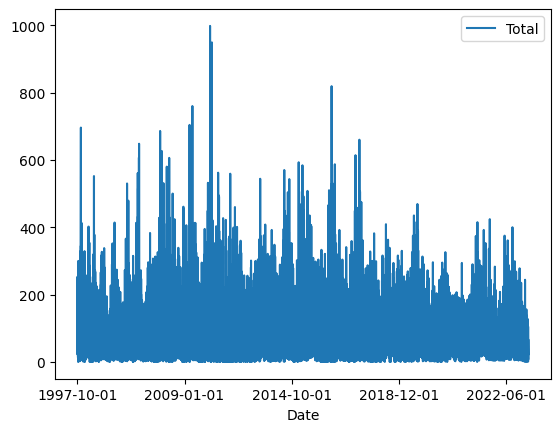

In [24]:
df_cote.plot()

<Axes: xlabel='Date'>

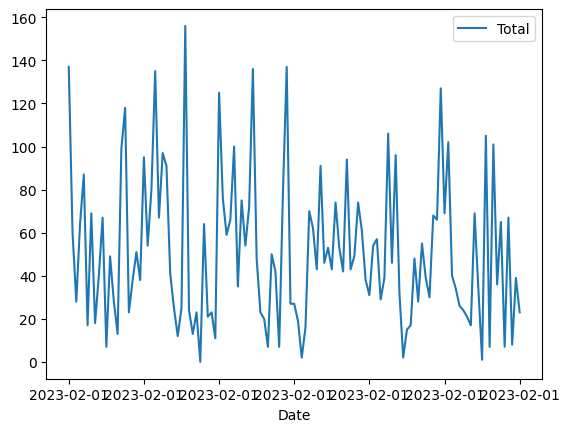

In [29]:
df_cote["2023-02-01":"2023-02-01"].plot()

POL: Dane są zbierane z różnych sektorów->pod-sektorów->drzew, tak więc na jeden miesiąc przypada wiele punktów co nie jest czymś pożądanym. Z tego względu z każdego miesiąca powinna zostać wyciągnięta suma zbiorów. Dlaczego suma? Wynika to z specyfikacji danych. W tym przypadku średnia oznaczałaby średnią wartość zbioru z jednego drzewa, natomiast nas interesuje suma zbioru w kraju z danego miesiąca.

ENG: The data are collected from different different sectors->sub-sectors->trees, so there are multiple points per month which is not something desirable. Therefore, a harvest total should be drawn from each month. Why a total? This is due to the specification of the data. In this case, average would mean the average value of the harvest from one tree, whereas we are interested in the total harvest in the country from a given month.

In [74]:
df_cote_monthly = df_cote.groupby('Date').sum()

<Axes: xlabel='Date'>

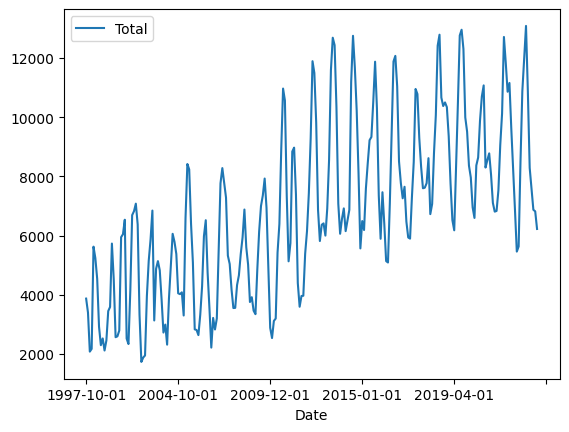

In [75]:
df_cote_monthly.plot()

POL: W danych o interwale miesięcznym znajdują się braki. Dane należy więc uzupełnić by zapewnić ciągłość stałego interwału czasowego.

ENG: There are deficiencies in the monthly interval data. The data should therefore be supplemented to ensure the continuity of the continuous time interval.

In [76]:
df_cote_monthly.index = pd.to_datetime(df_cote_monthly.index)

In [94]:
print(df_cote_monthly.head(1).index)
print(df_cote_monthly.tail(1).index.values[0])
period_array = pd.date_range(df_cote_monthly.head(1).index.values[0], df_cote_monthly.tail(1).index.values[0] + pd.DateOffset(months=1), freq='M')
period_array = [i.replace(day=1).date() for i in period_array]
period_array
df_full_period = pd.DataFrame(period_array)
df_full_period = df_full_period.rename(columns={0: 'Date'})
df_full_period["Value"] = 0
df_full_period.set_index('Date', inplace=True)


DatetimeIndex(['1997-10-01'], dtype='datetime64[ns]', name='Date', freq=None)
2023-02-01T00:00:00.000000000


In [95]:
df_full_period

,Value
Date,
1997-10-01,0
1997-11-01,0
1997-12-01,0
1998-01-01,0
1998-02-01,0
...,...
2022-10-01,0
2022-11-01,0
2022-12-01,0


In [100]:
df_cote_monthly_new = df_cote_monthly.reset_index().merge(df_full_period, how="right").set_index('index')

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [101]:
df_cote_monthly_new = pd.merge(df_cote_monthly, df_full_period, right_index=True, left_index=True, how='right')

In [107]:
df_cote_monthly_new = df_cote_monthly_new.drop(columns=['Value'])

In [112]:
df_cote_monthly_new.index = pd.to_datetime(df_cote_monthly_new.index)

             Total
Date              
1997-10-01  3873.0
1997-11-01     NaN
1997-12-01     NaN
1998-01-01  3400.0
1998-02-01     NaN
...            ...
2022-10-01  8291.0
2022-11-01  7598.0
2022-12-01  6874.0
2023-01-01  6822.0
2023-02-01  6226.0

[305 rows x 1 columns]


<Axes: xlabel='Date'>

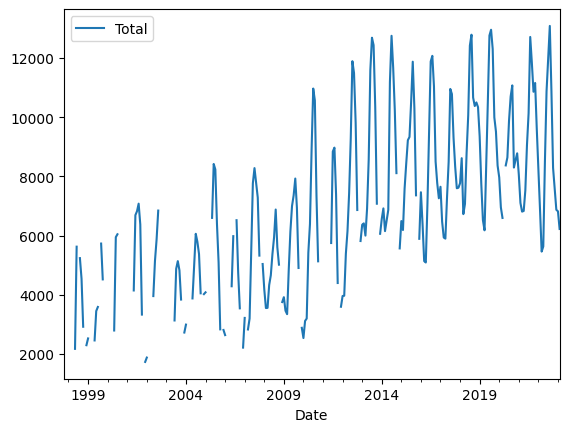

In [113]:
print(df_cote_monthly_new)
df_cote_monthly_new.plot()

In [115]:
df_cote_monthly_new_interpolate = df_cote_monthly_new.interpolate()

                  Total
Date                   
1997-10-01  3873.000000
1997-11-01  3715.333333
1997-12-01  3557.666667
1998-01-01  3400.000000
1998-02-01  2740.500000
...                 ...
2022-10-01  8291.000000
2022-11-01  7598.000000
2022-12-01  6874.000000
2023-01-01  6822.000000
2023-02-01  6226.000000

[305 rows x 1 columns]


<Axes: xlabel='Date'>

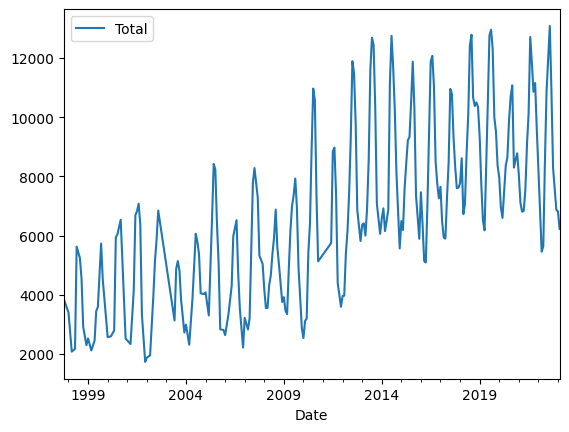

In [116]:
print(df_cote_monthly_new_interpolate)
df_cote_monthly_new_interpolate.plot()

In [117]:
df_cote_monthly_new_interpolate.index = df_cote_monthly_new_interpolate.index.to_period('M')

In [118]:
df_cote_monthly_new_interpolate

,Total
Date,
1997-10,3873.000000
1997-11,3715.333333
1997-12,3557.666667
1998-01,3400.000000
1998-02,2740.500000
...,...
2022-10,8291.000000
2022-11,7598.000000
2022-12,6874.000000


## Decomposition

In [119]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [121]:
df_cote_monthly_new_interpolate.index=df_cote_monthly_new_interpolate.index.to_timestamp()

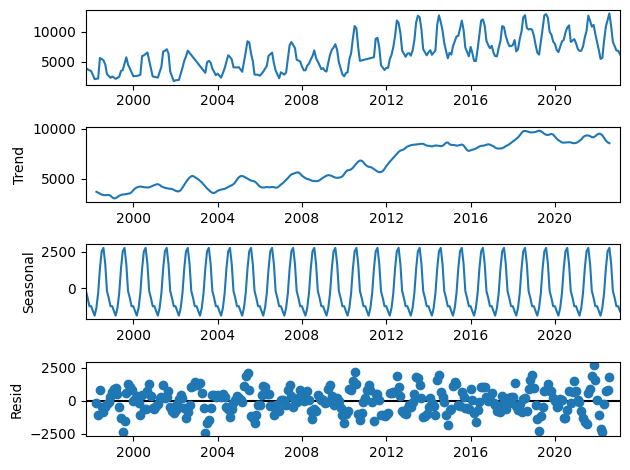

In [128]:
result = seasonal_decompose(df_cote_monthly_new_interpolate)
result.plot();

POL: Szereg czasowy charakteryzuje się silną sezonowością i widocznym trendem wzrostowym. Sezonowość może być dobrze wyjaśniona przez naturę zbiorów jakichkolwiek upraw. Uprawy muszą rosnąć, więc w szczycie zbiorów będzie ich najwięcej, podczas gdy poza sezonem będzie ich bardzo mało. Widoczny trend może być spowodowany postępującym rozrostem plantacji.

ENG: The time series has strong seasonality and visible upward trend. Seasonality can be well explained by the nature of harvesting any crop. Crops need to grow, so at the peak of the harvest there will be the most, whereas in the off-season, there will be very little. Visible trend can be caused by the progressive growth of plantations.

## ACF: the autocorrelation function

In [129]:
from statsmodels.graphics.tsaplots import plot_acf

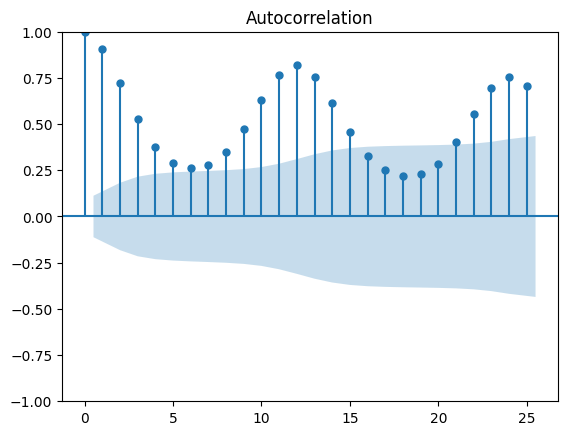

In [131]:
plot_acf(df_cote_monthly_new_interpolate);

## PACF: the partial autocorrelation function

In [132]:
from statsmodels.graphics.tsaplots import plot_pacf

g:\My Drive\Master's thesis\Cocoa-yield-forecast\venv-cocoa-yield-forecast\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


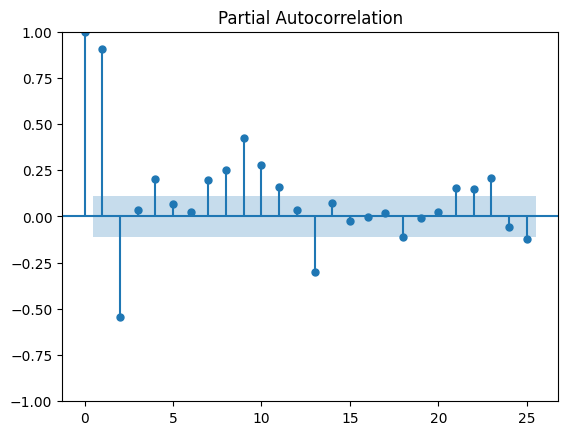

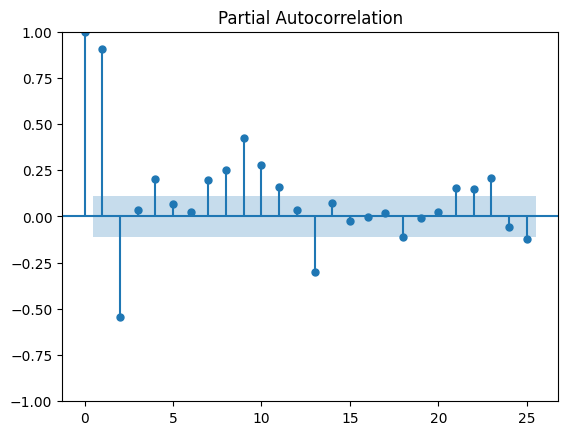

In [133]:
plot_pacf(df_cote_monthly_new_interpolate)

In [134]:
from pandas.plotting import lag_plot

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

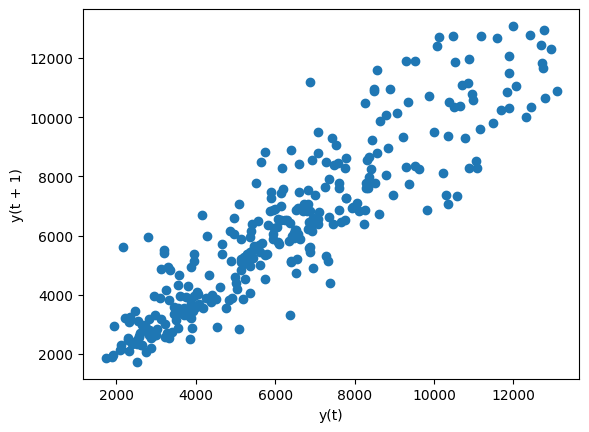

In [135]:
lag_plot(df_cote_monthly_new_interpolate)

POL: Widoczna jest pewna autokorelacja w badanym szeregu czasowym (punkty ustawione są wzdłuż przekątnej).

ENG: Some autocorrelation is apparent in the time series studied (points are aligned along the diagonal).

## Stationarity: Dickey-Fuller test

In [136]:
from statsmodels.tsa.stattools import adfuller

In [138]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df_cote_monthly_new_interpolate.Total.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -1.3403318118192886
ADF p-values: 0.6105245287280866
ADF number of lags used: 12
ADF number of observations: 292
ADF critical values: {'1%': -3.4529449243622383, '5%': -2.871489553425686, '10%': -2.572071437887033}
ADF best information criterion: 4675.459057755774


POL: p-wartość jest powyżej 0.05 a więc nie można przyjąć hipotezy alternatywnej o stacjonarności. Szereg czasowy jest więc nie-stacjonarny.

ENG: The p-value is above 0.05 and so the alternative hypothesis of stationarity cannot be accepted. The time series is therefore non-stationary.

<Axes: xlabel='Date'>

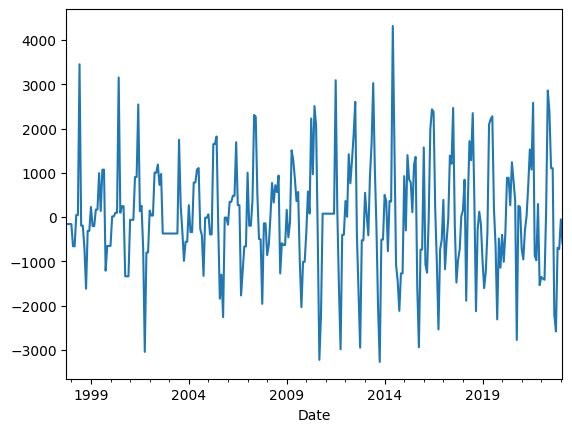

In [139]:
prev_df_cote_monthly_new_interpolate_value = df_cote_monthly_new_interpolate.Total.shift()
differenced_prev_df_cote_monthly_new_interpolate = df_cote_monthly_new_interpolate.Total - prev_df_cote_monthly_new_interpolate_value
differenced_prev_df_cote_monthly_new_interpolate.plot()

In [140]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(differenced_prev_df_cote_monthly_new_interpolate.dropna())
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -7.188467810323907
ADF p-values: 2.5401349018319354e-10
ADF number of lags used: 11
ADF number of observations: 292
ADF critical values: {'1%': -3.4529449243622383, '5%': -2.871489553425686, '10%': -2.572071437887033}
ADF best information criterion: 4660.310791574763


In [141]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [144]:
df_cote_monthly_new_interpolate

,Total
Date,
1997-10-01,3873.000000
1997-11-01,3715.333333
1997-12-01,3557.666667
1998-01-01,3400.000000
1998-02-01,2740.500000
...,...
2022-10-01,8291.000000
2022-11-01,7598.000000
2022-12-01,6874.000000


In [145]:
train, test = train_test_split(df_cote_monthly_new_interpolate.Total.values, train_size=0.8)

In [150]:
train.shape

(244,)

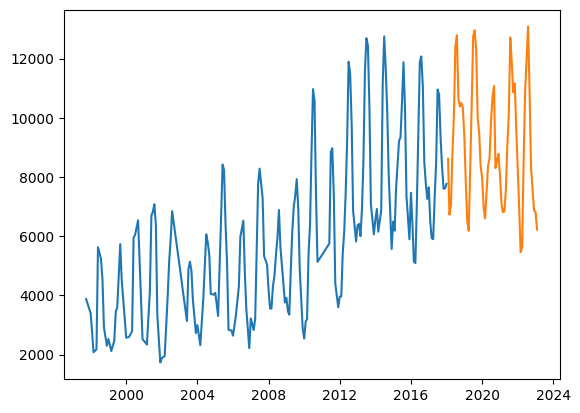

In [153]:
# df_cote_monthly_new_interpolate.iloc[:train.shape[0]].plot()
plt.plot(df_cote_monthly_new_interpolate.iloc[:train.shape[0]])
plt.plot(df_cote_monthly_new_interpolate.iloc[train.shape[0]:])

In [154]:
model = pm.auto_arima(train, seasonal=True, m=15)
preds = model.predict(test.shape[0])

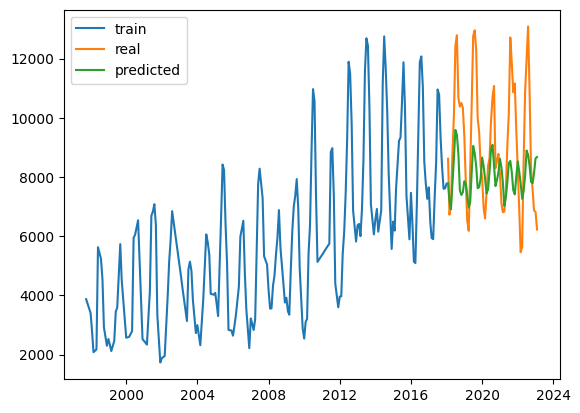

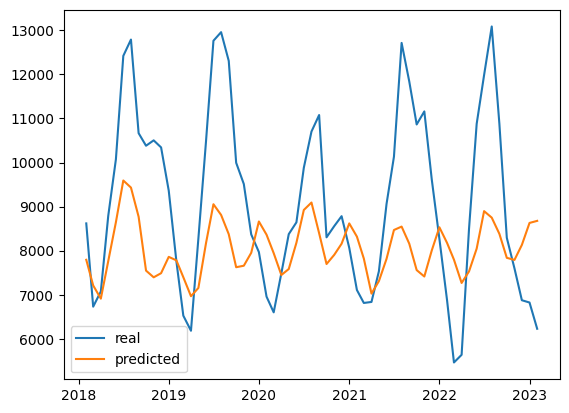

In [167]:
plt.plot(df_cote_monthly_new_interpolate.iloc[:train.shape[0]].index.values, train, label="train")
plt.plot(df_cote_monthly_new_interpolate.iloc[train.shape[0]:], label="real")
plt.plot(df_cote_monthly_new_interpolate.iloc[train.shape[0]:].index.values, preds, label="predicted")
plt.legend()
plt.show();
plt.plot(df_cote_monthly_new_interpolate.iloc[train.shape[0]:], label="real")
plt.plot(df_cote_monthly_new_interpolate.iloc[train.shape[0]:].index.values, preds, label="predicted")
plt.legend()
plt.show();

In [169]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [177]:
print(type(df_cote_monthly_new_interpolate.iloc[train.shape[0]:].Total.values))
print(type(preds))
print(df_cote_monthly_new_interpolate.iloc[train.shape[0]:].index.values.shape)
print(preds.shape)
print(df_cote_monthly_new_interpolate.iloc[train.shape[0]:].Total.values)
print("**************")
print(preds)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(61,)
(61,)
[ 8618.   6728.   7073.   8790.  10073.  12421.  12791.  10666.  10381.
 10503.  10343.   9361.   7756.   6524.   6181.   8273.  10487.  12764.
 12959.  12307.   9995.   9512.   8368.   7968.   6956.   6599.   7486.5
  8374.   8642.   9881.  10703.  11078.   8302.   8555.   8782.   8063.
  7106.   6812.   6835.   7531.   9060.  10133.  12715.  11840.  10864.
 11160.   9621.   8269.   6876.   5461.   5635.   8495.  10878.  11984.
 13088.  10875.   8291.   7598.   6874.   6822.   6226. ]
**************
[7791.84742936 7209.16068678 6909.84282137 7762.35481498 8644.98129408
 9591.64471425 9430.76778497 8769.30728318 7546.33416882 7394.01772156
 7487.93987222 7858.58537835 7778.77689464 7397.00538431 6965.63890656
 7152.22501151 8173.35130354 9052.83992618 8810.30844711 8372.55231435
 7623.18693803 7657.3621796  7950.97793386 8661.71702608 8362.2019772
 7942.75227235 7446.26372564 7582.35000806 8178.25628019 8922.73684936
 9091.979

In [179]:
rmse = sqrt(mean_squared_error(df_cote_monthly_new_interpolate.iloc[train.shape[0]:].Total.values, preds))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2088.074


## Linear regression

In [181]:
import numpy as np

# extract the seasonality data
months = [x.month for x in df_cote_monthly_new_interpolate.index]
years = [x.year for x in df_cote_monthly_new_interpolate.index]
print(months)
print(years)

# convert into one matrix
X = np.array([months, years]).T
print(X)

[10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
[1997,

In [182]:
from sklearn.linear_model import LinearRegression

In [183]:
# fit the model
my_lr = LinearRegression()
my_lr.fit(X, df_cote_monthly_new_interpolate.Total.values)

# predict on the same period
preds = my_lr.predict(X)

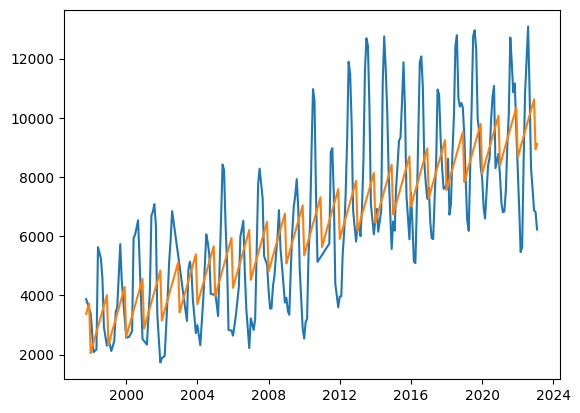

In [184]:
# plot what has been learned
plt.plot(df_cote_monthly_new_interpolate.index, df_cote_monthly_new_interpolate.Total.values)
plt.plot(df_cote_monthly_new_interpolate.index, preds)

In [185]:
rmse = sqrt(mean_squared_error(df_cote_monthly_new_interpolate.Total.values, preds))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1887.047


## Random forest

In [189]:
from sklearn.ensemble import RandomForestRegressor

In [193]:
train, test = train_test_split(X, train_size=0.8)
print(train.shape[0])

# fit the model
my_rf = RandomForestRegressor()
my_rf.fit(train, df_cote_monthly_new_interpolate.iloc[:train.shape[0]].Total.values)

# predict on the same period
preds = my_rf.predict(test)

244


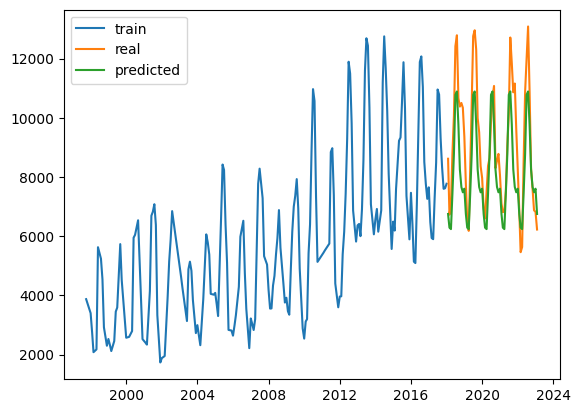

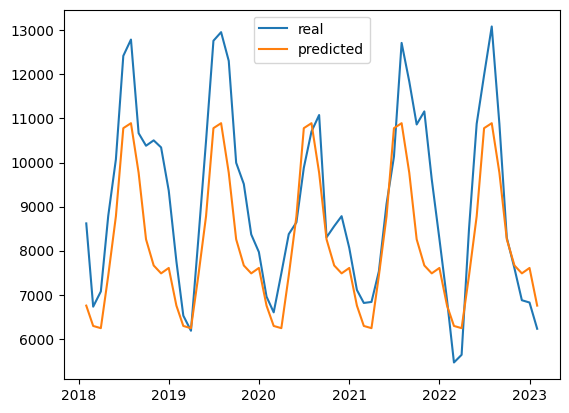

In [202]:
# # plot what has been learned
# plt.plot(df_cote_monthly_new_interpolate.index, df_cote_monthly_new_interpolate.Total.values)
# plt.plot(df_cote_monthly_new_interpolate.index, preds)

plt.plot(df_cote_monthly_new_interpolate.iloc[:train.shape[0]].index.values, df_cote_monthly_new_interpolate.iloc[:train.shape[0]].Total.values, label="train")
plt.plot(df_cote_monthly_new_interpolate.iloc[train.shape[0]:], label="real")
plt.plot(df_cote_monthly_new_interpolate.iloc[train.shape[0]:].index.values, preds, label="predicted")
plt.legend()
plt.show();
plt.plot(df_cote_monthly_new_interpolate.iloc[train.shape[0]:], label="real")
plt.plot(df_cote_monthly_new_interpolate.iloc[train.shape[0]:].index.values, preds, label="predicted")
plt.legend()
plt.show();

In [197]:
rmse = sqrt(mean_squared_error(df_cote_monthly_new_interpolate.iloc[train.shape[0]:].Total.values, preds))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1411.987


## XGBoost

In [203]:
import xgboost as xgb

# fit the model
my_xgb = xgb.XGBRegressor()
my_xgb.fit(train, df_cote_monthly_new_interpolate.iloc[:train.shape[0]].Total.values)

my_rf = RandomForestRegressor()
my_rf.fit(train, df_cote_monthly_new_interpolate.iloc[:train.shape[0]].Total.values)

# predict on the same period
preds = my_xgb.predict(test)

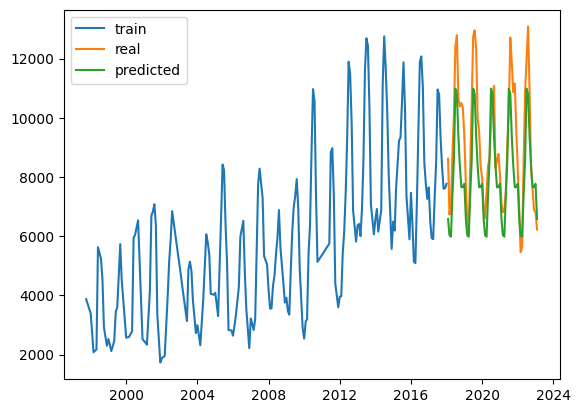

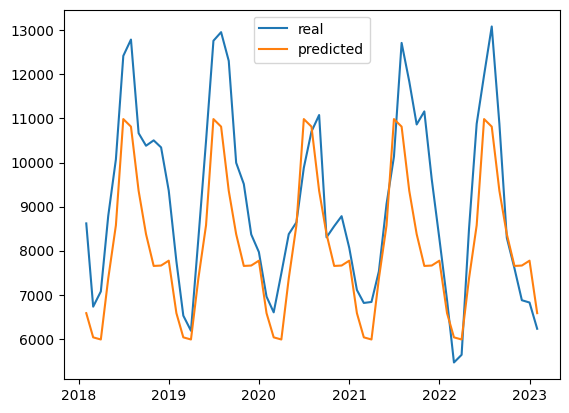

In [204]:
plt.plot(df_cote_monthly_new_interpolate.iloc[:train.shape[0]].index.values, df_cote_monthly_new_interpolate.iloc[:train.shape[0]].Total.values, label="train")
plt.plot(df_cote_monthly_new_interpolate.iloc[train.shape[0]:], label="real")
plt.plot(df_cote_monthly_new_interpolate.iloc[train.shape[0]:].index.values, preds, label="predicted")
plt.legend()
plt.show();
plt.plot(df_cote_monthly_new_interpolate.iloc[train.shape[0]:], label="real")
plt.plot(df_cote_monthly_new_interpolate.iloc[train.shape[0]:].index.values, preds, label="predicted")
plt.legend()
plt.show();

In [205]:
rmse = sqrt(mean_squared_error(df_cote_monthly_new_interpolate.iloc[train.shape[0]:].Total.values, preds))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1466.145
